<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [6]:
random.seed(0)

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [15]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [16]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [17]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [18]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [19]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [20]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

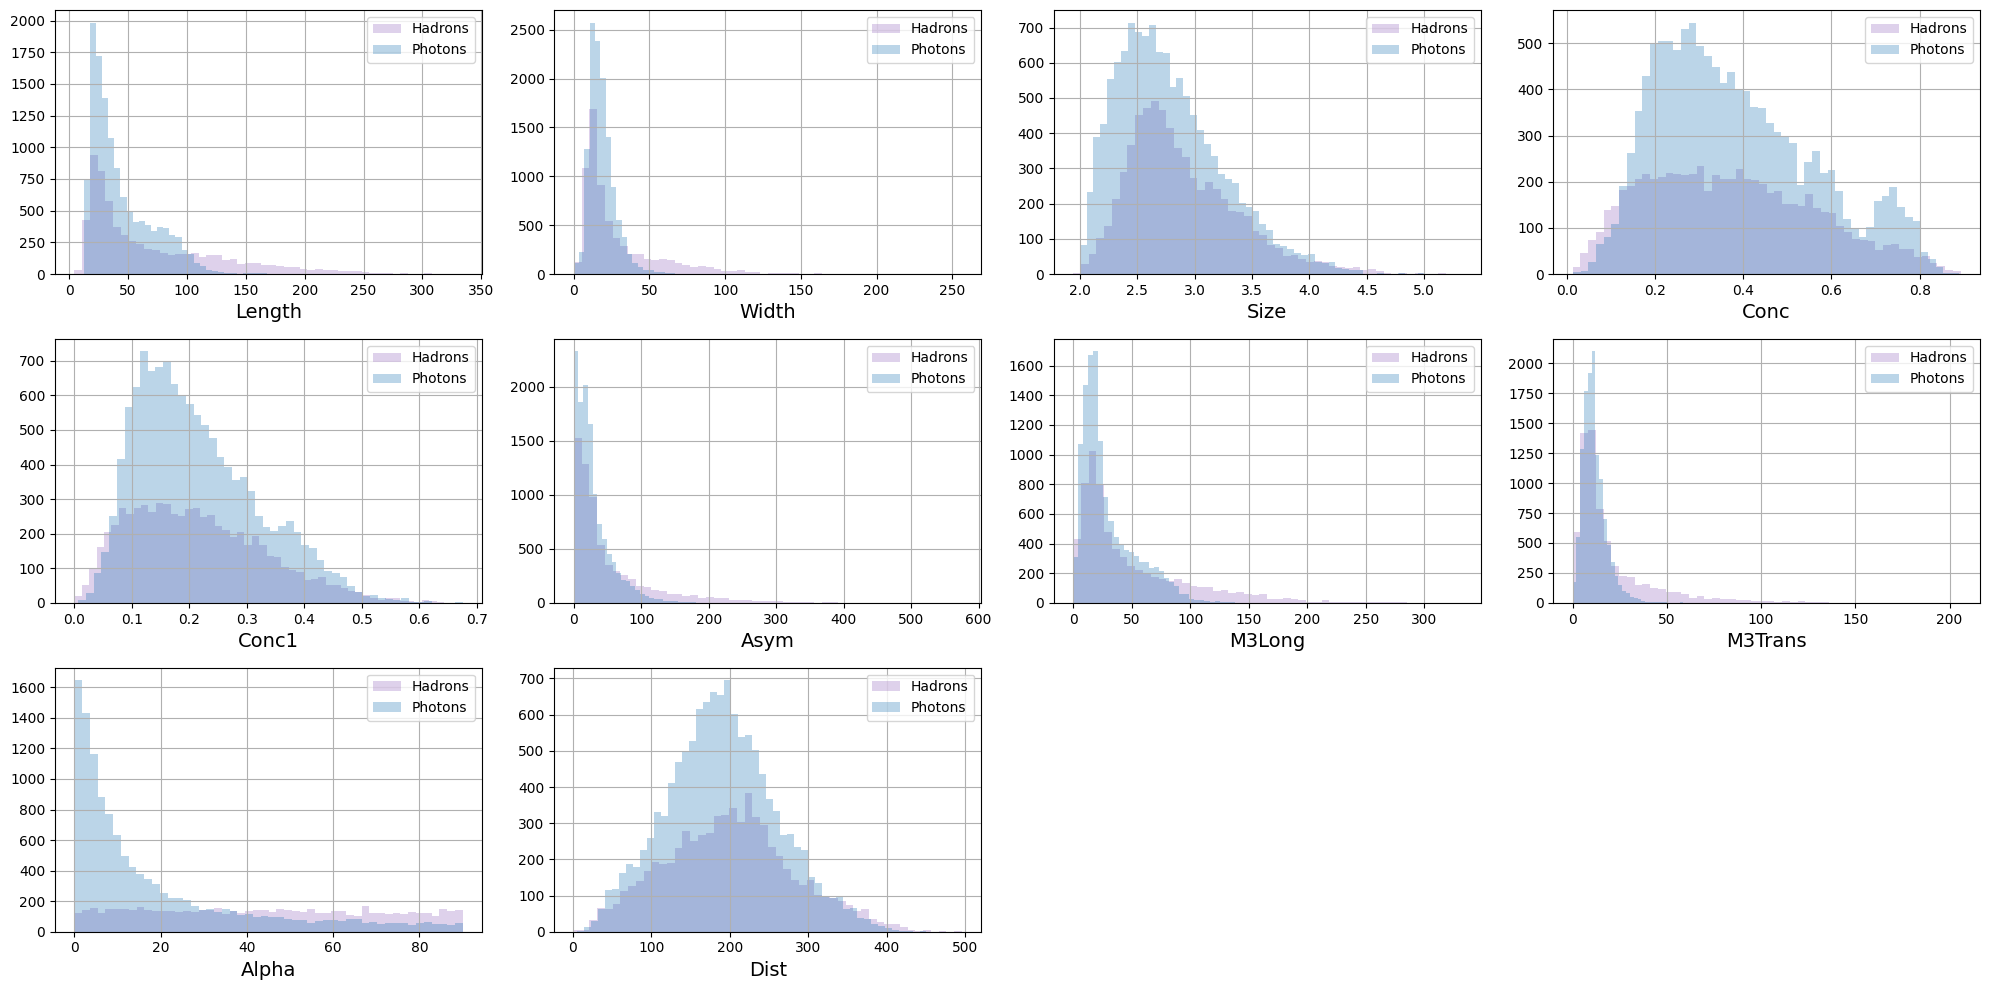

In [21]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [22]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

In [23]:
X_train.shape

(9510, 10)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

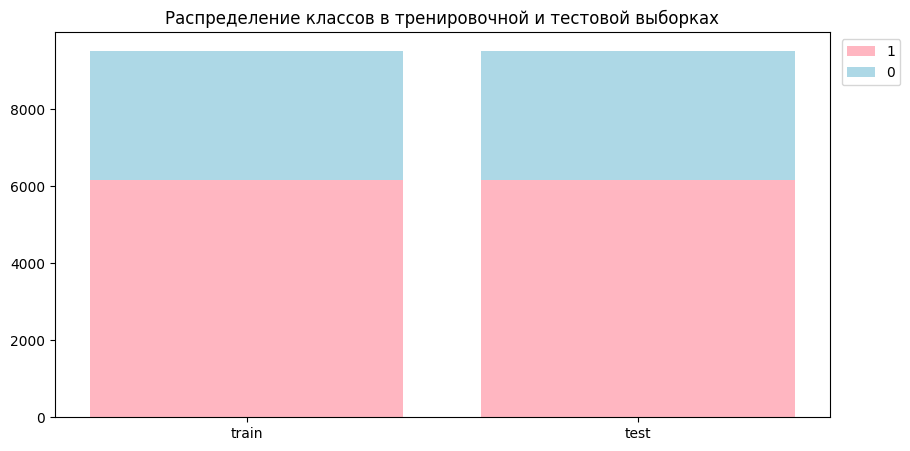

In [24]:
x = ['train', 'test']
y1 = [len(y_train[y_train == 1]), len(y_test[y_test == 1])]
y2 = [len(y_train[y_train == 0]), len(y_train[y_test == 0])]

plt.figure(figsize=(10, 5))
plt.bar(x, y1, color='lightpink', label='1')
plt.bar(x, y2, bottom=y1, color='lightblue', label='0')
plt.title('Распределение классов в тренировочной и тестовой выборках')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [25]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

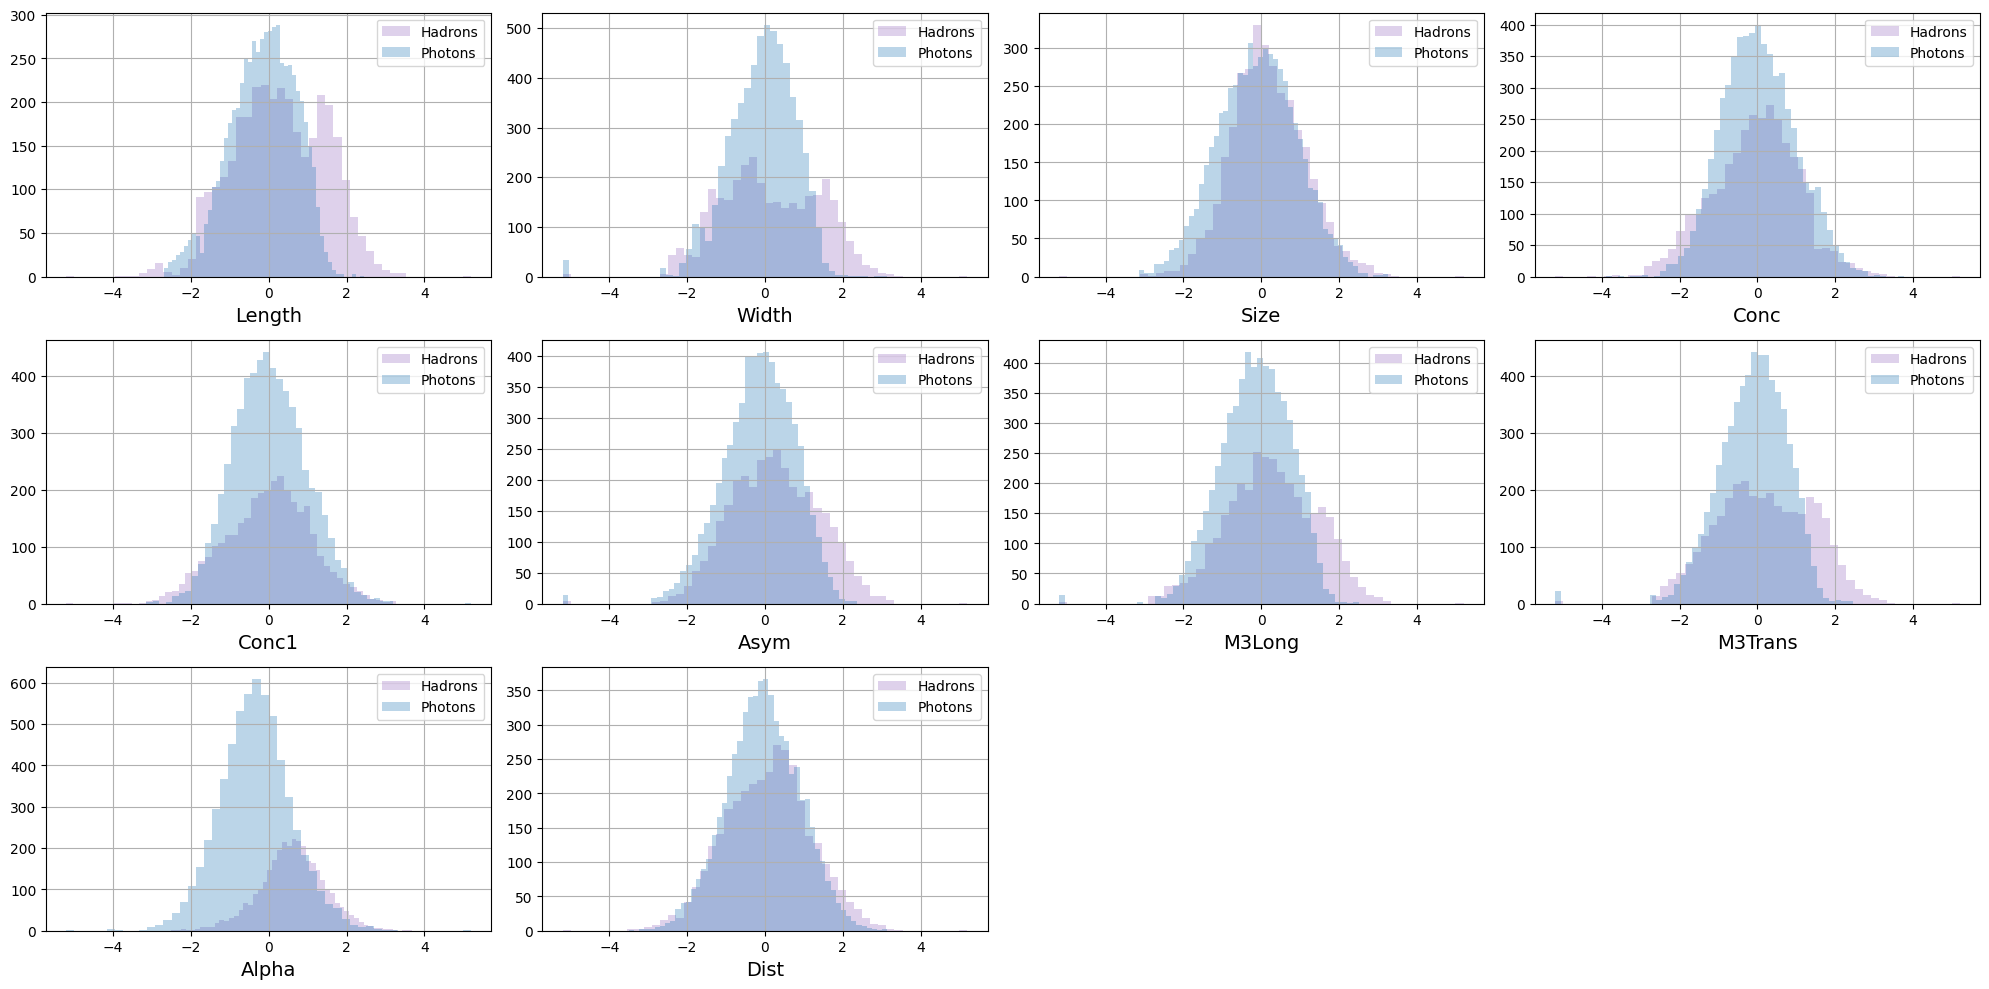

In [26]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

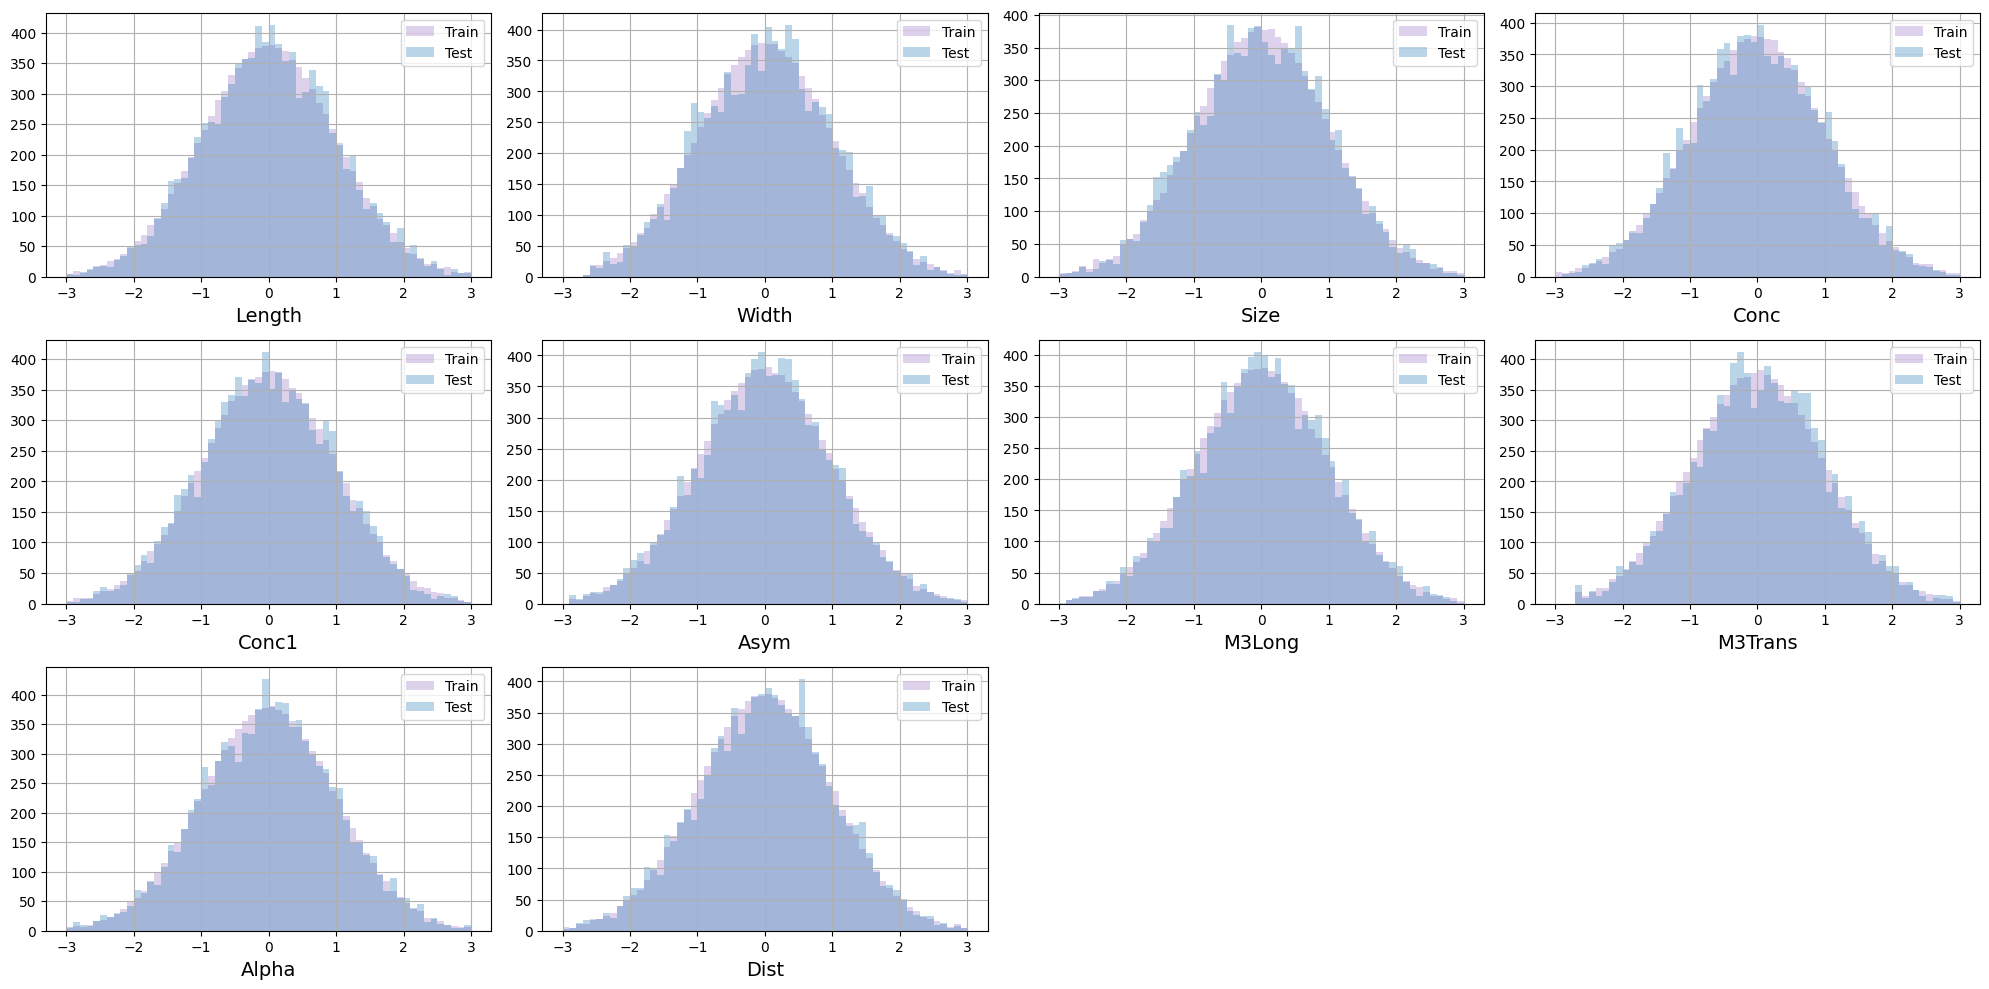

In [27]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [30]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новых объектов $X$ по вектору условий $y$.

In [31]:
def generate(generator, y, latent_dim):
    Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
    X_fake = generator(Z_noise, y)
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [32]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.Linear(100, 1),
            nn.ReLU(),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [34]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    real_obj = torch.cat((X_real, y_real), dim=1)
    fake_obj = torch.cat((X_fake, y_fake), dim=1)

    real_y = torch.ones(len(real_obj))
    fake_y = torch.zeros(len(fake_obj))

    X = torch.cat([real_obj, fake_obj], dim=0)
    y = torch.cat([real_y, fake_y], dim=0)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, shuffle=True)

    clf1 = LogisticRegression().fit(X_train, y_train)
    clf2 = GradientBoostingClassifier().fit(X_train, y_train)

    lin_reg_score = accuracy_score(y_test, clf1.predict(X_test))
    boosting_score = accuracy_score(y_test, clf2.predict(X_test))

    print("Logistic regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [38]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        gen_loss_trace = []
        disc_loss_trace = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # генерируем новые объекты
                num_objects = real_batch.shape[0]
                prior = torch.distributions.Normal(
                torch.zeros(10).to(DEVICE), torch.ones(10).to(DEVICE))
                z = prior.sample((num_objects,))
                gen_objects = generator(z, cond_batch)

                # считаем скоры
                real_objects_scores, gen_objects_scores = torch.split(
                discriminator(torch.cat([real_batch, gen_objects], dim=0),
                torch.cat([cond_batch, cond_batch], dim=0)), num_objects)

                if i % self.n_critic == 0 and i != 0:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = -gen_objects_scores.mean()
                    gen_loss.backward()
                    self.opt_gen.step()
                    gen_loss_trace.append((i, gen_loss.item()))
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    disc_loss = gen_objects_scores.mean() - real_objects_scores.mean()
                    disc_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    disc_loss_trace.append((i, disc_loss.item()))

                ### THE END OF YOUR CODE ###

            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            X_real_sample = X_real[:1000]
            Z_noise = torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE)
            X_fake_sample = self.generator(Z_noise, y_cond[:1000])
            y_real_sample, y_fake_sample = y_cond[:1000], y_cond[:1000]
            other_agent_score(X_real_sample.detach().cpu(), y_real_sample.cpu(), X_fake_sample.detach().cpu(), y_fake_sample.cpu())
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [39]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Logistic regression score: 0.612
Boosting score: 0.848
Logistic regression score: 0.582
Boosting score: 0.824
Logistic regression score: 0.542
Boosting score: 0.78
Logistic regression score: 0.538
Boosting score: 0.76
Logistic regression score: 0.566
Boosting score: 0.76
Logistic regression score: 0.516
Boosting score: 0.692
Logistic regression score: 0.518
Boosting score: 0.698
Logistic regression score: 0.508
Boosting score: 0.722
Logistic regression score: 0.516
Boosting score: 0.698
Logistic regression score: 0.514
Boosting score: 0.718
Logistic regression score: 0.61
Boosting score: 0.744
Logistic regression score: 0.49
Boosting score: 0.714
Logistic regression score: 0.56
Boosting score: 0.706
Logistic regression score: 0.538
Boosting score: 0.682
Logistic regression score: 0.53
Boosting score: 0.694
Logistic regression score: 0.524
Boosting score: 0.666
Logistic regression score: 0.478
Boosting score: 0.656
Logistic regression score: 0.49
Boosting score: 0.7
Logistic regression 

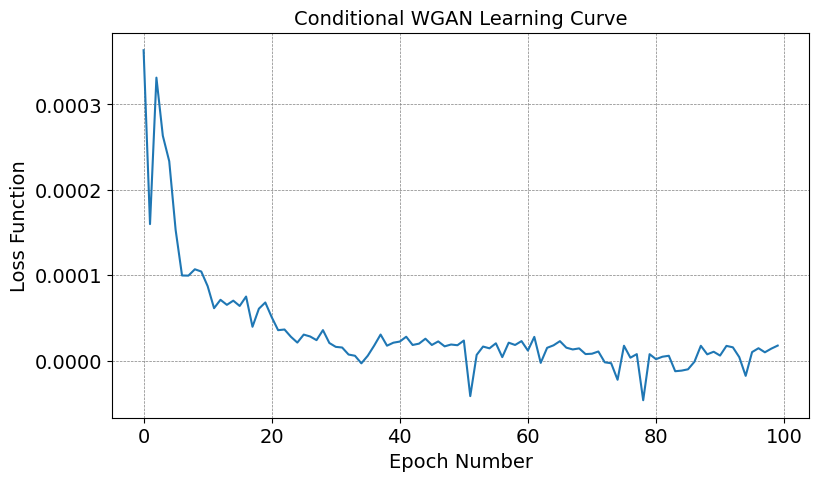

In [40]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [41]:
### YOUR CODE IS HERE ######

X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

### THE END OF YOUR CODE ###

In [42]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=DEVICE)

In [43]:
X_fake_train = generate(fitter.generator, y_train_tensor, latent_dim)

In [44]:
X_fake_train = qt.inverse_transform(X_fake_train.detach().cpu())

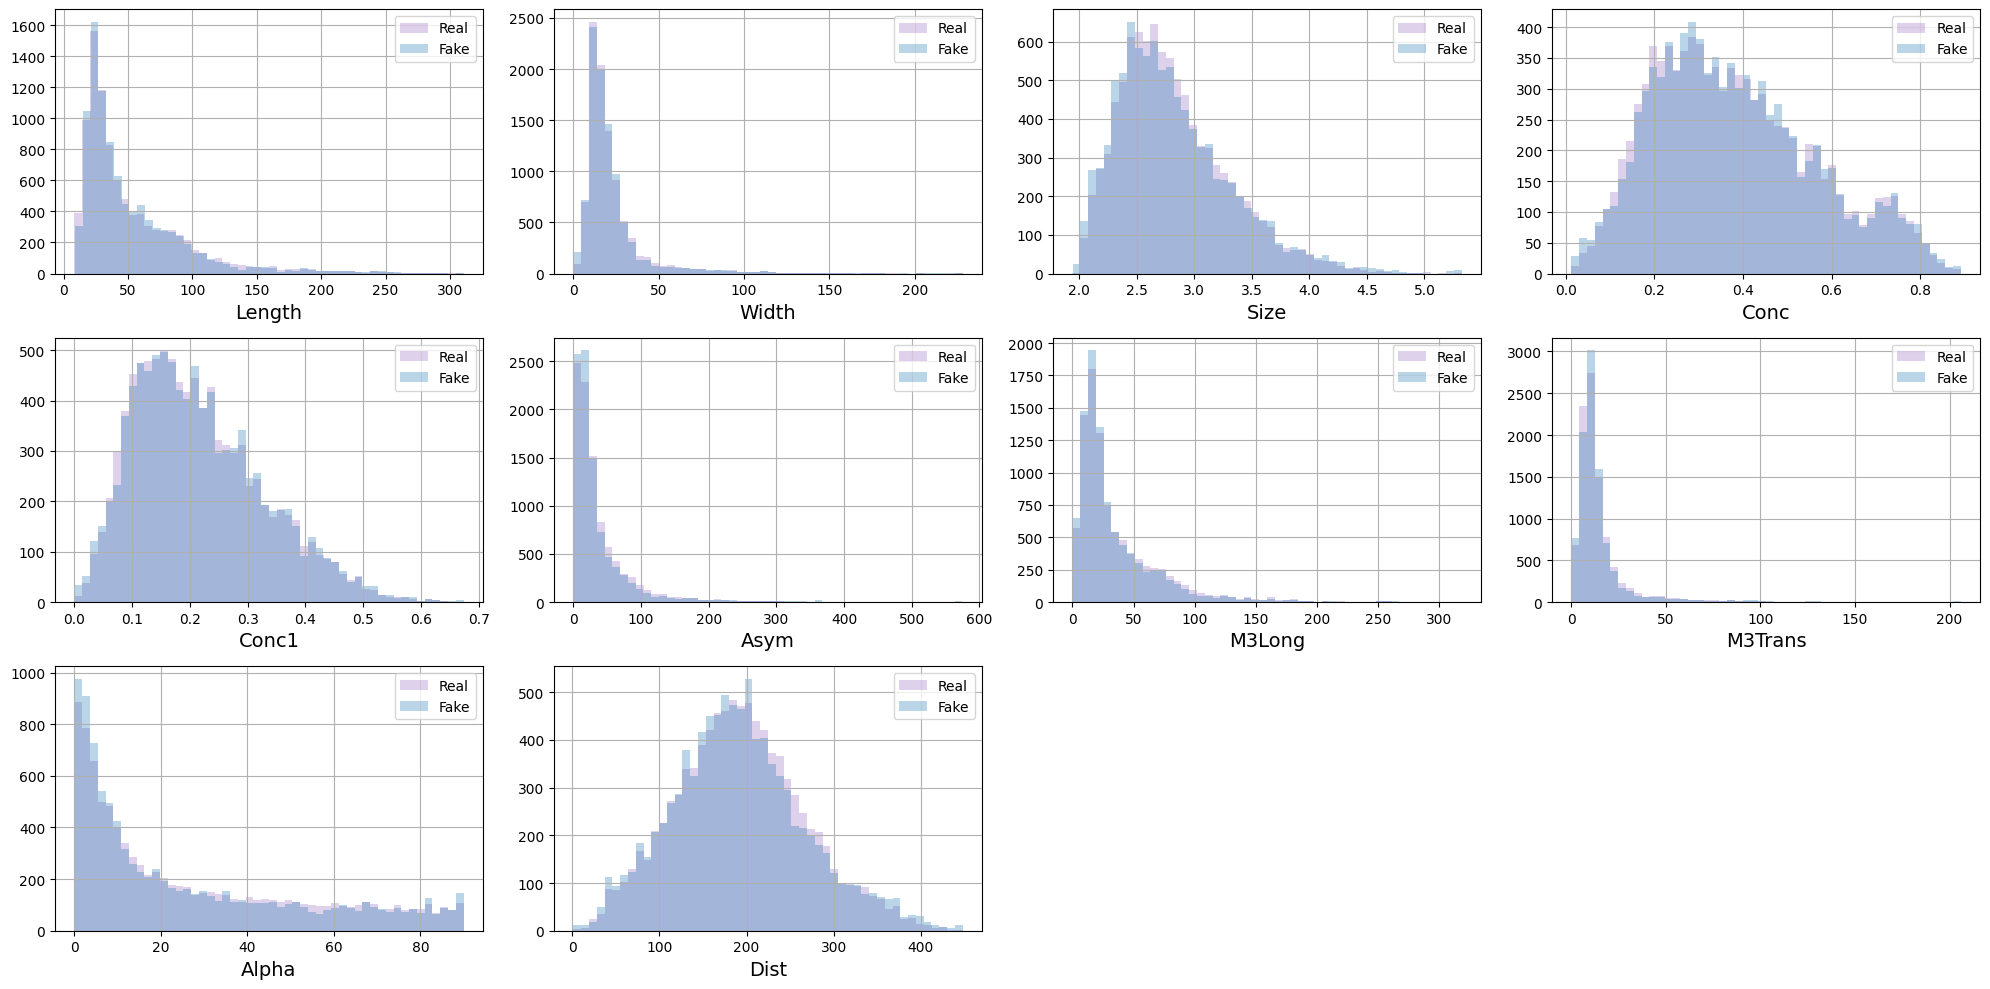

In [45]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [46]:
y_test_tensor = torch.tensor(y_train, dtype=torch.float, device=DEVICE)

In [47]:
X_fake_test = generate(fitter.generator, y_test_tensor, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test.detach().cpu())

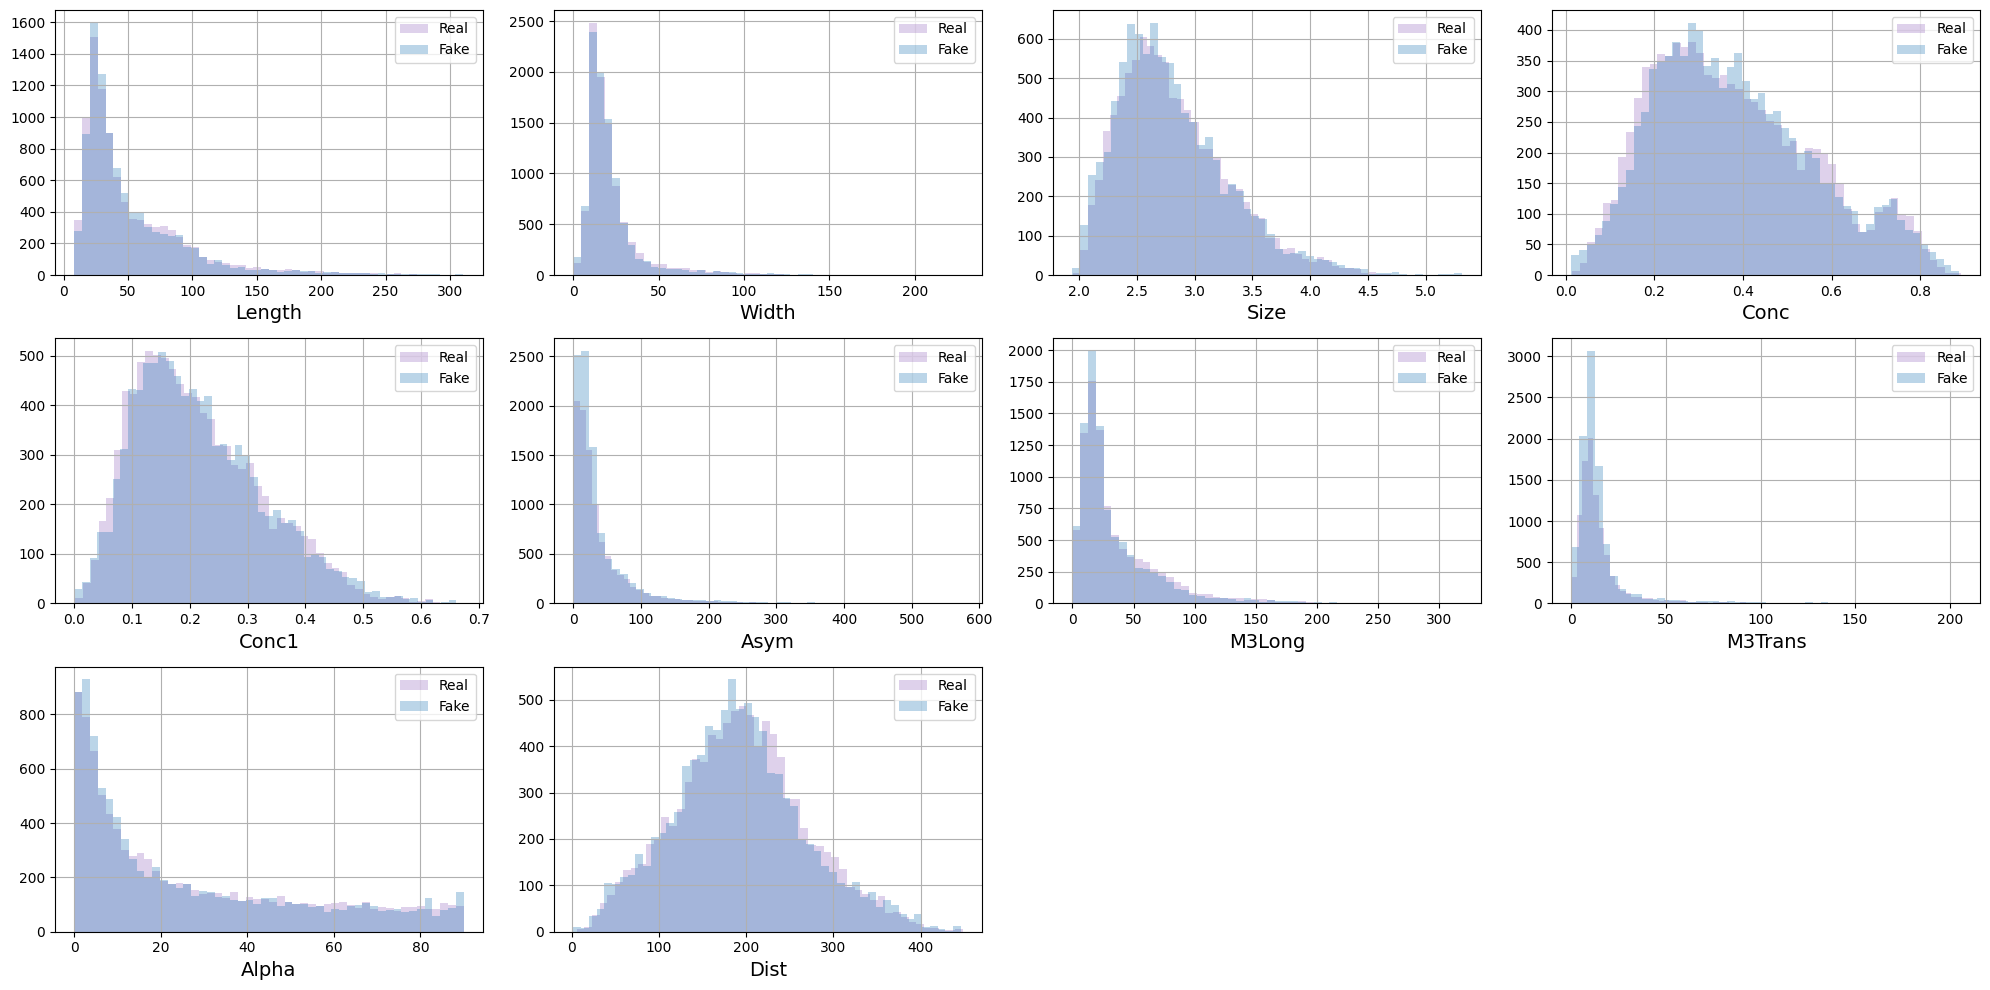

In [48]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [49]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [51]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6866544320495002


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Результат средний. Наверное, нас удовлетворит значение ближе к 0.5, так как это будет значить, что дискриминатор плохо отличает реальные и фейковые объекты, а значит, мы сгенерировали действительно похожие объекты.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [132]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

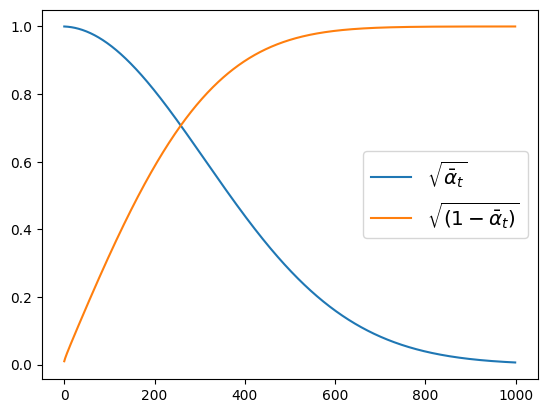

In [52]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
#!pip install diffusers -q

In [133]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.model(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [134]:
from tqdm.auto import tqdm

In [135]:
def generate_with_diffusion(model, y, latent_dim):

    ### YOUR CODE IS HERE ######

    n_steps = 5
    x = torch.rand(y.shape[0], latent_dim, device=DEVICE)
    for i in range(n_steps):
        with torch.no_grad():
            pred = model(x, y)
        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor

    ### THE END OF YOUR CODE ###

    return x.detach().cpu()  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [136]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.loss_fn = nn.MSELoss() # добавила лосс функцию
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit Diffusion
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for x, y in tqdm( #изменила этот кусок кода, добавила progress bar
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                x = x.to(DEVICE)
                noise_amount = torch.rand(x.shape[0]).to(DEVICE)
                noisy_x = corrupt(x, noise_amount)
                pred = self.model(noisy_x, y)

                loss = self.loss_fn(pred, x)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                loss_epoch += loss.cpu().detach()

                ### THE END OF YOUR CODE ###

            # calculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######

            X_real_sample2 = X_real[:1000]
            y_cond2 = y_cond[:1000]
            X_fake_sample2 = generate_with_diffusion(self.model, y_cond2[:1000], self.latent_dim)
            other_agent_score(X_real_sample2.detach().cpu(), y_cond2.cpu(), X_fake_sample2.detach().cpu(), y_cond2.cpu())

            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [137]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

  0%|          | 0/191 [00:00<?, ?it/s]

Logistic regression score: 1.0
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

Logistic regression score: 1.0
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

Logistic regression score: 0.996
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

Logistic regression score: 1.0
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.996
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.998
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.998
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.996
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.996
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.996
Boosting score: 1.0


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.994
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.998
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.994
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.99
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.994
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.982
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.976
Boosting score: 0.986


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.974
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.978
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.972
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.958
Boosting score: 0.992


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.972
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.954
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.96
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.958
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.96
Boosting score: 0.988


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.946
Boosting score: 0.986


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.948
Boosting score: 0.998


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.938
Boosting score: 0.99


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.932
Boosting score: 0.99


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.932
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.918
Boosting score: 0.994


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.914
Boosting score: 0.99


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.914
Boosting score: 0.996


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.904
Boosting score: 0.992


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.902
Boosting score: 0.988


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.87
Boosting score: 0.974


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.872
Boosting score: 0.98


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.872
Boosting score: 0.972


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.84
Boosting score: 0.978


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.82
Boosting score: 0.978


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.802
Boosting score: 0.98


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.844
Boosting score: 0.976


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.766
Boosting score: 0.974


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.736
Boosting score: 0.96


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.734
Boosting score: 0.96


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.7
Boosting score: 0.972


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.762
Boosting score: 0.962


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.666
Boosting score: 0.982


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.628
Boosting score: 0.96


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.596
Boosting score: 0.968


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.618
Boosting score: 0.976


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.59
Boosting score: 0.976


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.668
Boosting score: 0.98


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.59
Boosting score: 0.954


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.61
Boosting score: 0.952


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.578
Boosting score: 0.966


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.522
Boosting score: 0.952


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.532
Boosting score: 0.958


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.548
Boosting score: 0.954


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.554
Boosting score: 0.972


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.584
Boosting score: 0.952


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.534
Boosting score: 0.958


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.584
Boosting score: 0.948


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.552
Boosting score: 0.974


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.582
Boosting score: 0.962


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.532
Boosting score: 0.95


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.644
Boosting score: 0.954


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.658
Boosting score: 0.956


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.632
Boosting score: 0.962


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.574
Boosting score: 0.946


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.58
Boosting score: 0.948


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.636
Boosting score: 0.95


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.554
Boosting score: 0.958


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.594
Boosting score: 0.942


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.582
Boosting score: 0.966


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.566
Boosting score: 0.964


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.616
Boosting score: 0.944


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.586
Boosting score: 0.95


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.688
Boosting score: 0.96


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.576
Boosting score: 0.94


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.636
Boosting score: 0.948


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.57
Boosting score: 0.962


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.638
Boosting score: 0.948


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.556
Boosting score: 0.938


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.522
Boosting score: 0.936


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.58
Boosting score: 0.952


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.544
Boosting score: 0.948


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.594
Boosting score: 0.952


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.65
Boosting score: 0.954


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.508
Boosting score: 0.932


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.634
Boosting score: 0.952
CPU times: user 1min 55s, sys: 14.5 s, total: 2min 9s
Wall time: 2min 1s


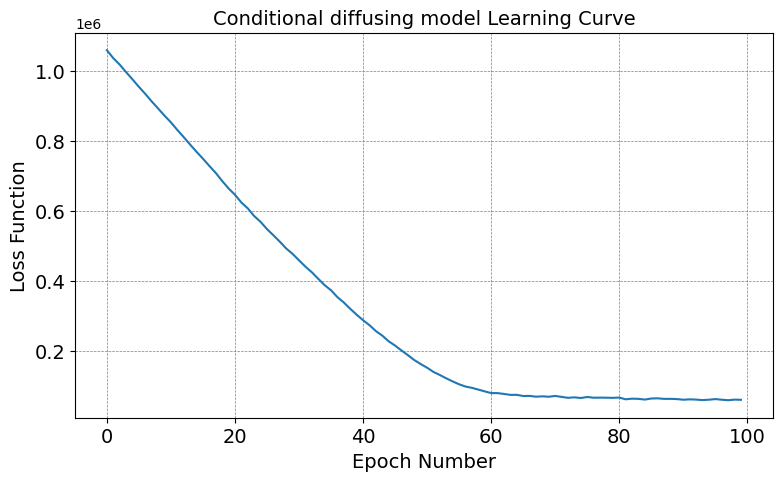

In [139]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [140]:
# обучаем классификатор
clf_diff = GradientBoostingClassifier()
clf_diff.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf_diff.predict_proba(XX_test)[:, 1]

In [141]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6867520546748621


У меня получилось примерно одно и тоже, но я не оптимизировала диффузию и взяла все самое базовое. Наверное, чтобы диффузия дала результат, нужно покопаться и применить какие-то более сложные алгоритмы. Однако график обучения более гладкий, чем у ганов.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

ИАД - прекрасный курс. Без Евгения Соколова, конечно, грустно, но другие преподаватели и семинаристы (Филипп Ульянкин, Михаил Гущин) тоже на высоте, все очень хорошо!